# <center> Прототип решения по Треку 3:</center> <center> «Предсказание вероятности возникновения ДТП»</center>

## Постановка задачи

Разработать алгоритм прогнозирующий наиболее вероятную категорию события дорожно-транспортного происшествия (далее по тексту «ДТП»):

>1. ДТП не произойдет
>1. ДТП произойдет без пострадавших
>1. ДТП произойдет с пострадавшими

Данные для обучения — информация о ДТП от ГИБДД и ВНИИ ГОЧС, а также дополнительные данные по интенсивности движения, метеоусловиях на участках дороги и др. В качестве федеральных автомобильных дорог рассматриваются М-8 «Холмогоры» и Р-21 «Кола».

## Прототип решения

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import numpy as np
import re
import functools
from geopy.distance import geodesic
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import numpy as np
import plotly.express as px
from tqdm.notebook import tqdm


In [2]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### 1. Подготовка датасета для обучения модели

In [3]:
df = pd.read_csv('../data/train.csv', usecols=[0, 1, 2, 9, 10], parse_dates=['datetime'])
df = df[df['road_km'] < 1550]
df = df[df['road_id'].isin([9, 14])]
df = df.sort_values('datetime', ascending=True)
# TODO обрезать от 2016 года. кажется что данные по авариями там были не полные. Особенно от ГИБДД 
df = df[df['datetime'] > '2016-01-01']
df.reset_index(drop=True, inplace=True)
df['target'] = df['target'].replace({3,2})#.value_counts()
df

datetime  road_id  road_km data_source  target
0     2016-01-01 06:00:00        9       23       gibdd       1
1     2016-01-01 08:00:00       14       76       gibdd       1
2     2016-01-01 13:00:00        9       78       gibdd       1
3     2016-01-01 17:00:00        9       41       gibdd       1
4     2016-01-01 23:00:00        9       19       gibdd       1
...                   ...      ...      ...         ...     ...
36768 2021-03-30 20:00:00        9      303       gochs       2
36769 2021-03-31 10:00:00        9      218       gochs       2
36770 2021-03-31 11:00:00        9      212       gochs       2
36771 2021-04-03 11:00:00       14       60       gochs       2
36772 2021-04-03 18:00:00       14     1392       gochs       2

[36773 rows x 5 columns]

In [4]:
test = pd.read_csv('../data/test.csv', parse_dates=['datetime'])
test = test.sort_values('datetime', ascending=True)
# TODO обрезать от 2016 года. кажется что данные по авариями там были не полные. Особенно от ГИБДД 
test.reset_index(drop=True, inplace=True)
test

datetime  road_id  road_km  target
0       2020-01-01 01:00:00        9        0     NaN
1       2020-01-01 01:00:00       14      620     NaN
2       2020-01-01 01:00:00       14      621     NaN
3       2020-01-01 01:00:00       14      622     NaN
4       2020-01-01 01:00:00       14      623     NaN
...                     ...      ...      ...     ...
1729446 2020-10-25 23:00:00        9      926     NaN
1729447 2020-10-25 23:00:00        9      927     NaN
1729448 2020-10-25 23:00:00        9      928     NaN
1729449 2020-10-25 23:00:00        9      920     NaN
1729450 2020-10-25 23:00:00       14     1549     NaN

[1729451 rows x 4 columns]

In [5]:
q = test[test['road_id'] == 9]
q['road_km'].value_counts()

1023    623
137     623
1158    623
135     623
647     623
       ... 
308     623
820     623
309     623
0       623
1226      2
Name: road_km, Length: 1227, dtype: int64

In [6]:
dates = pd.date_range('2016-01-01','2019-12-31',freq='H')

In [7]:
gen_df9 = pd.DataFrame(columns=['datetime', 'road_km'])
gen_df9['road_km'] = [i for i in range(1, 1250) for i in range(1000)]
gen_df9['choise'] = np.random.choice(len(dates), gen_df9.shape[0])
gen_df9['datetime'] = gen_df9['choise'].apply(lambda x: dates[x])
gen_df9['road_id'] = 9
gen_df9['target'] = 0
gen_df9

datetime  road_km  choise  road_id  target
0       2017-02-18 19:00:00        0    9955        9       0
1       2017-03-04 10:00:00        1   10282        9       0
2       2017-06-14 03:00:00        2   12723        9       0
3       2018-04-26 00:00:00        3   20304        9       0
4       2018-03-14 15:00:00        4   19287        9       0
...                     ...      ...     ...      ...     ...
1248995 2016-03-09 03:00:00      995    1635        9       0
1248996 2018-04-27 16:00:00      996   20344        9       0
1248997 2019-02-03 17:00:00      997   27113        9       0
1248998 2017-03-21 18:00:00      998   10698        9       0
1248999 2018-08-13 19:00:00      999   22939        9       0

[1249000 rows x 5 columns]

In [9]:
gen_df14 = pd.DataFrame(columns=['datetime', 'road_km'])
gen_df14['road_km'] = [i for i in range(1, 1550) for i in range(1000)]
gen_df14['choise'] = np.random.choice(len(dates), gen_df14.shape[0])
gen_df14['datetime'] = gen_df14['choise'].apply(lambda x: dates[x])
gen_df14['road_id'] = 14
gen_df14['target'] = 0
gen_df14

datetime  road_km  choise  road_id  target
0       2016-07-11 10:00:00        0    4618       14       0
1       2017-09-11 15:00:00        1   14871       14       0
2       2016-07-04 11:00:00        2    4451       14       0
3       2017-11-09 06:00:00        3   16278       14       0
4       2016-10-12 21:00:00        4    6861       14       0
...                     ...      ...     ...      ...     ...
1548995 2019-08-20 04:00:00      995   31852       14       0
1548996 2016-11-02 05:00:00      996    7349       14       0
1548997 2017-02-17 17:00:00      997    9929       14       0
1548998 2016-09-25 02:00:00      998    6434       14       0
1548999 2018-06-03 05:00:00      999   21221       14       0

[1549000 rows x 5 columns]

In [10]:
cond = gen_df9[['datetime', 'road_km', 'road_id']].isin(df[['datetime', 'road_km', 'road_id']]).any(axis=1)
gen_df9 = gen_df9.drop(gen_df9[cond].index)
gen_df9

datetime  road_km  choise  road_id  target
1       2017-03-04 10:00:00        1   10282        9       0
6       2017-09-30 16:00:00        6   15328        9       0
14      2016-07-05 04:00:00       14    4468        9       0
15      2019-09-30 07:00:00       15   32839        9       0
16      2017-05-24 02:00:00       16   12218        9       0
...                     ...      ...     ...      ...     ...
1248995 2016-03-09 03:00:00      995    1635        9       0
1248996 2018-04-27 16:00:00      996   20344        9       0
1248997 2019-02-03 17:00:00      997   27113        9       0
1248998 2017-03-21 18:00:00      998   10698        9       0
1248999 2018-08-13 19:00:00      999   22939        9       0

[1225033 rows x 5 columns]

In [11]:
cond = gen_df14[['datetime', 'road_km', 'road_id']].isin(df[['datetime', 'road_km', 'road_id']]).any(axis=1)
gen_df14 = gen_df14.drop(gen_df14[cond].index)
gen_df14

datetime  road_km  choise  road_id  target
0       2016-07-11 10:00:00        0    4618       14       0
2       2016-07-04 11:00:00        2    4451       14       0
3       2017-11-09 06:00:00        3   16278       14       0
4       2016-10-12 21:00:00        4    6861       14       0
5       2018-07-01 01:00:00        5   21889       14       0
...                     ...      ...     ...      ...     ...
1548995 2019-08-20 04:00:00      995   31852       14       0
1548996 2016-11-02 05:00:00      996    7349       14       0
1548997 2017-02-17 17:00:00      997    9929       14       0
1548998 2016-09-25 02:00:00      998    6434       14       0
1548999 2018-06-03 05:00:00      999   21221       14       0

[1536159 rows x 5 columns]

In [12]:
cols = ['datetime', 'road_id', 'road_km', 'target']
df_full = pd.concat([df[cols], gen_df14[cols], gen_df9[cols]])
df_full

datetime  road_id  road_km  target
0       2016-01-01 06:00:00        9       23       1
1       2016-01-01 08:00:00       14       76       1
2       2016-01-01 13:00:00        9       78       1
3       2016-01-01 17:00:00        9       41       1
4       2016-01-01 23:00:00        9       19       1
...                     ...      ...      ...     ...
1248995 2016-03-09 03:00:00        9      995       0
1248996 2018-04-27 16:00:00        9      996       0
1248997 2019-02-03 17:00:00        9      997       0
1248998 2017-03-21 18:00:00        9      998       0
1248999 2018-08-13 19:00:00        9      999       0

[2797965 rows x 4 columns]

In [13]:
df_full['target'].value_counts()

0    2761192
1      30355
2       6410
3          8
Name: target, dtype: int64

In [14]:
df_full['type'] = 'train'
test['type'] = 'test'

df_full = df_full.append(test)
df_full = df_full.reset_index(drop=True)
df_full.shape

(4527416, 5)

#### Тренеровочный датасет (`train.csv`):
> 1. **datetime** - дата события в формате `yyyy-MM-dd hh-mm-ss`
> 1. **road_id** - код автодороги, принимает одно из трех значений:
>    * 5 — М-4 (E115) “Дон” Москва - Новороссийск;
>    * 9 — М-8 (E115) “Холмогоры” Москва - Архангельск через Ярославль, Вологду;
>    * 4 — М-18 / Р-21 (E105) “Кола” С.Петербург - Мурманск через Петрозаводск.
> 1. **road_km** - км участка на котором произошло ДТП
> 1. **data_source** - источник данных события. В датасете атрибут принимает одно из двух значений:
>    * gibdd - ГИБДД;
>    * gochs - МЧС.
> 1. **target** - целевой признак является ли событие ДТП. В датасете атрибут принимает одно из четырех значений:
>    * 1 - ДТП без пострадавших;
>    * 2 - ДТП с пострадавшими;
>    * 3 - ЧС (объявляется от 5 погибших и/или 10 пострадавших)* в тестовой выборке события отсутствуют0 - событие не является ДТП;

#### Обагащение выборки переменными из датасетов `traffic.csv`

In [15]:
traffic = pd.read_csv('../data/traffic2.csv', parse_dates=['datetime'])

# Drop duplicates
traffic = traffic.drop_duplicates()

condition1 = (traffic["road_id"].isin(['9', '14']))
condition2 = (traffic['datetime'] > '2016-01-01')
traffic = traffic[condition1 & condition2]

# repair = pd.read_csv('../data/repair.csv', parse_dates=['datetime'])

In [16]:
# def hour_rounder(t):
#     return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
#                +timedelta(hours=t.minute//30))
# # округление переменной datetime до часа
# traffic['datetime'] = traffic['datetime'].map(lambda x: hour_rounder(x))
# traffic.to_csv('../data/traffic2.csv')

In [17]:
# Сделать признак float км.метр дороги
# traffic['road_m'] = traffic['name'].apply(lambda x: int(x.split('+')[1].split(' ')[0]))
# traffic['road_km_full'] = traffic['road_km'].astype('str') + '.' + traffic['road_m'].astype('str')
# traffic['road_km_full'] = traffic['road_km_full'].astype(float)
# traffic

In [23]:
from tqdm.notebook import tqdm

# Perform merge  of traffic with df
def find_closest_camera(df, road_id):
    df_road = df[df['road_id'] == road_id].copy()
    
    road_unique_km = traffic[traffic['road_id'] == road_id]['road_km'].unique()
    
    camera_traffic = {num: i for num, i in enumerate(road_unique_km)}

    # temporary df for camera position columns
    camera_df = pd.DataFrame(index=df_road.index)
    for num, camera_km in tqdm(camera_traffic.items()):
        camera_df[num] = df_road['road_km'].sub(camera_km).abs()#.idxmin()

    # айди ближайшей камеры (уникальный км.)
    df_road['camera_closest_idx'] = camera_df.idxmin(axis=1)
    # айди ближайшей камеры (уникальный км.)
    df_road['camera_closest_idx_km'] = df_road['camera_closest_idx'].replace(camera_traffic)
    df_road['road_id'] = df_road['road_id'].fillna(road_id)

    return df_road, camera_df

df_road9, camera_df9 = find_closest_camera(df_full, road_id=9)
df_road14, camera_df14 = find_closest_camera(df_full, road_id=14)
df_road9.shape, df_road14.shape

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

((2012793, 7), (2514623, 7))

In [25]:
df_road14['type'].value_counts()

train    1548972
test      965651
Name: type, dtype: int64

In [26]:
traffic_mean = traffic.rename(columns={'road_km':'camera_closest_idx_km'})
traffic_mean = traffic_mean.groupby(['datetime', 'camera_closest_idx_km', 'road_id']).agg({'volume': [np.mean, np.max, np.min], 
                                                                           'occupancy': [np.mean, np.max, np.min], 
                                                                           'speed': [np.mean, np.max, np.min]}
                                                                         ).reset_index()

traffic_mean.columns = ['datetime', 'camera_closest_idx_km', 'road_id', 'volume_mean', 'volume_max', 'volume_min', 
                        'occupancy_mean','occupancy_max', 'occupancy_min', 'speed_mean', 'speed_max', 
                        'speed_min']

traffic_mean

datetime  camera_closest_idx_km  road_id  volume_mean  \
0       2016-01-01 01:00:00                     16       14   137.000000   
1       2016-01-01 01:00:00                     26       14    81.000000   
2       2016-01-01 01:00:00                     45       14   180.666667   
3       2016-01-01 01:00:00                     84       14    63.000000   
4       2016-01-01 01:00:00                    108       14    27.200000   
...                     ...                    ...      ...          ...   
2324984 2021-04-14 11:00:00                    181        9   175.500000   
2324985 2021-04-14 12:00:00                    181        9   200.000000   
2324986 2021-04-14 13:00:00                    181        9   236.500000   
2324987 2021-04-14 14:00:00                    181        9   385.000000   
2324988 2021-04-15 21:00:00                    181        9     0.000000   

         volume_max  volume_min  occupancy_mean  occupancy_max  occupancy_min  \
0             326.0         0.0        0.767578       1.785156       0.000000   
1             216.0         6.0        0.614583       1.109375       0.261719   
2             244.0       126.0        1.472656       1.820312       1.140625   
3              76.0        50.0        0.787109       0.925781       0.648438   
4              76.0         0.0        0.614063       1.855469       0.000000   
...             ...         ...             ...            ...            ...   
2324984       177.0       174.0        4.000000       4.000000       4.000000   
2324985       204.0       196.0        4.000000       5.000000       3.000000   
2324986       251.0       222.0        4.500000       6.000000       3.000000   
2324987       407.0       363.0        9.000000       9.000000       9.000000   
2324988         0.0         0.0        9.500000      12.000000       7.000000   

         speed_mean  speed_max  speed_min  
0         76.276458  106.71750    0.00000  
1         86.402708  113.16750   48.97875  
2         81.603333   88.26750   78.06000  
3         74.535000   78.07000   71.00000  
4         46.285250   72.00625    0.00000  
...             ...        ...        ...  
2324984   68.415000   69.08000   67.75000  
2324985   69.157500   70.63500   67.68000  
2324986   69.000000   70.27000   67.73000  
2324987   66.090000   69.00000   63.18000  
2324988   64.000000   69.00000   59.00000  

[2324989 rows x 12 columns]

In [27]:
# Perform merge  of traffic with df
# left - обогатить только данные аварий
# outer - данные аварий и всю остальную инфу о трафике
def merge_traffic_df(df, road_id):
    traffic_temp = traffic_mean[traffic_mean['road_id'] == road_id].copy()
    df_traffic = df.merge(traffic_temp, on=['datetime', 'camera_closest_idx_km', 'road_id'], 
                          how = 'outer', suffixes=('_traffic', '_mean'))

    df_traffic['target'] = df_traffic['target'].fillna(0)

    df_traffic['road_km'] = df_traffic['road_km'].fillna(df_traffic['camera_closest_idx_km'])

    return df_traffic

df_traffic9 = merge_traffic_df(df=df_road9, road_id=9)
df_traffic14 = merge_traffic_df(df=df_road14, road_id=14)

In [28]:
# del df_road9
# del df_road14

In [29]:
# renew camera_df after outer merge where additional rows were added
def create_renewed_camera_df(df_traffic, road_id):
    df_traffic['road_km'] = df_traffic['road_km'].fillna(df_traffic['camera_closest_idx_km'])

    road_unique_km = traffic[traffic['road_id'] == road_id]['road_km'].unique()
    
    # temporary df for camera position columns
    camera_df = pd.DataFrame(index=df_traffic.index)
    for num, camera_km in enumerate(tqdm(road_unique_km)):
        camera_df[num] = df_traffic['road_km'].sub(camera_km).abs()#.idxmin()

    # айди ближайшей камеры (уникальный км.)
    df_traffic['camera_closest_idx'] = camera_df.idxmin(axis=1)
    # айди ближайшей камеры (уникальный км.)
    df_traffic['camera_closest_idx_km'] = df_traffic['camera_closest_idx'].replace(road_unique_km)

    df_traffic['road_id'] = df_traffic['road_id'].fillna(road_id)
    return camera_df, df_traffic

camera_df9, df_traffic9 = create_renewed_camera_df(df_traffic=df_traffic9, road_id=9)
camera_df9.shape, df_traffic9.shape

  0%|          | 0/33 [00:00<?, ?it/s]

((2547787, 33), (2547787, 16))

In [30]:
camera_df14, df_traffic14 = create_renewed_camera_df(df_traffic=df_traffic14, road_id=14)
camera_df14.shape, df_traffic14.shape

  0%|          | 0/34 [00:00<?, ?it/s]

((3308852, 34), (3308852, 16))

In [31]:
df_traffic14['type'].value_counts()

train    1548972
test      965651
Name: type, dtype: int64

In [32]:
df_traffic9['type'].value_counts()

train    1248993
test      763800
Name: type, dtype: int64

In [33]:
def generate_camera_distance_features(df_traffic, camera_df):
    # Расстояние до ближайшей камеры
    df_traffic['camera_closest_dist'] = camera_df.min(axis=1)
    # Кол-во камер в радиусе 1 км
    df_traffic['camera_amount_1_km'] = (camera_df.T < 1).sum()
    # Кол-во камер в радиусе 2 км
    df_traffic['camera_amount_2_km'] = (camera_df.T < 2).sum()
    # Кол-во камер в радиусе 5 км
    df_traffic['camera_amount_5_km'] = (camera_df.T < 5).sum()
    return df_traffic

df_traffic9 = generate_camera_distance_features(df_traffic9, camera_df9)
df_traffic14 = generate_camera_distance_features(df_traffic14, camera_df14)

df_traffic9

datetime  road_id  road_km  target   type  \
0       2016-01-01 06:00:00        9     23.0     1.0  train   
1       2016-01-01 06:00:00        9     24.0     0.0  train   
2       2016-01-01 13:00:00        9     78.0     1.0  train   
3       2016-01-01 13:00:00        9     78.0     0.0  train   
4       2016-01-01 17:00:00        9     41.0     1.0  train   
...                     ...      ...      ...     ...    ...   
2547782 2021-04-14 11:00:00        9    181.0     0.0    NaN   
2547783 2021-04-14 12:00:00        9    181.0     0.0    NaN   
2547784 2021-04-14 13:00:00        9    181.0     0.0    NaN   
2547785 2021-04-14 14:00:00        9    181.0     0.0    NaN   
2547786 2021-04-15 21:00:00        9    181.0     0.0    NaN   

         camera_closest_idx  camera_closest_idx_km  volume_mean  volume_max  \
0                        27                     27          NaN         NaN   
1                        27                     27          NaN         NaN   
2                        24                     24          NaN         NaN   
3                        24                     24          NaN         NaN   
4                        23                     24          NaN         NaN   
...                     ...                    ...          ...         ...   
2547782                   1                      1        175.5       177.0   
2547783                   1                      1        200.0       204.0   
2547784                   1                      1        236.5       251.0   
2547785                   1                      1        385.0       407.0   
2547786                   1                      1          0.0         0.0   

         volume_min  occupancy_mean  occupancy_max  occupancy_min  speed_mean  \
0               NaN             NaN            NaN            NaN         NaN   
1               NaN             NaN            NaN            NaN         NaN   
2               NaN             NaN            NaN            NaN         NaN   
3               NaN             NaN            NaN            NaN         NaN   
4               NaN             NaN            NaN            NaN         NaN   
...             ...             ...            ...            ...         ...   
2547782       174.0             4.0            4.0            4.0     68.4150   
2547783       196.0             4.0            5.0            3.0     69.1575   
2547784       222.0             4.5            6.0            3.0     69.0000   
2547785       363.0             9.0            9.0            9.0     66.0900   
2547786         0.0             9.5           12.0            7.0     64.0000   

         speed_max  speed_min  camera_closest_dist  camera_amount_1_km  \
0              NaN        NaN                  0.0                   1   
1              NaN        NaN                  1.0                   0   
2              NaN        NaN                  1.0                   0   
3              NaN        NaN                  1.0                   0   
4              NaN        NaN                  3.0                   0   
...            ...        ...                  ...                 ...   
2547782     69.080      67.75                  0.0                   1   
2547783     70.635      67.68                  0.0                   1   
2547784     70.270      67.73                  0.0                   1   
2547785     69.000      63.18                  0.0                   1   
2547786     69.000      59.00                  0.0                   1   

         camera_amount_2_km  camera_amount_5_km  
0                         2                   3  
1                         1                   3  
2                         1                   1  
3                         1                   1  
4                         0                   2  
...                     ...                 ...  
2547782                   1                   1  
2547783                   1            

In [34]:
df_traffic14['type'].value_counts()

train    1548972
test      965651
Name: type, dtype: int64

In [35]:
df_traffic9['type'].value_counts()

train    1248993
test      763800
Name: type, dtype: int64

In [36]:
df_traffic = pd.concat([df_traffic9, df_traffic14])
df_traffic.shape

(5856639, 20)

In [37]:
# Генерация временных признаков
df_traffic['dt_year'] = 2021 - df_traffic['datetime'].dt.year # Количество лет до текущего года
df_traffic['dt_hour'] = df_traffic['datetime'].dt.hour
df_traffic['dt_dayofweek'] = df_traffic['datetime'].dt.dayofweek+1 # so monday will be 1
df_traffic['dt_day'] = df_traffic['datetime'].dt.day # of month
df_traffic['dt_dayofyear'] = df_traffic['datetime'].dt.dayofyear
# какой процент месяца остался до его завершения. (нормированное количество дней до конца месяца)
df_traffic['dt_monthProgress'] = (df_traffic['datetime'].dt.daysinmonth - df_traffic['datetime'].dt.day) / df_traffic['datetime'].dt.daysinmonth


train_cols = ['road_id', 'road_km',
    'dt_year', 'dt_hour', 'dt_dayofweek', 'dt_day', 'dt_dayofyear', 'dt_monthProgress']

df_traffic

datetime  road_id  road_km  target   type  \
0       2016-01-01 06:00:00        9     23.0     1.0  train   
1       2016-01-01 06:00:00        9     24.0     0.0  train   
2       2016-01-01 13:00:00        9     78.0     1.0  train   
3       2016-01-01 13:00:00        9     78.0     0.0  train   
4       2016-01-01 17:00:00        9     41.0     1.0  train   
...                     ...      ...      ...     ...    ...   
3308847 2021-04-14 08:00:00       14    494.0     0.0    NaN   
3308848 2021-04-14 08:00:00       14    608.0     0.0    NaN   
3308849 2021-04-14 08:00:00       14    797.0     0.0    NaN   
3308850 2021-04-14 08:00:00       14   1010.0     0.0    NaN   
3308851 2021-04-14 08:00:00       14   1074.0     0.0    NaN   

         camera_closest_idx  camera_closest_idx_km  volume_mean  volume_max  \
0                        27                     27          NaN         NaN   
1                        27                     27          NaN         NaN   
2                        24                     24          NaN         NaN   
3                        24                     24          NaN         NaN   
4                        23                     24          NaN         NaN   
...                     ...                    ...          ...         ...   
3308847                  33                     33     9.000000         9.0   
3308848                  13                     13    47.333333        80.0   
3308849                   2                      2     5.000000         6.0   
3308850                  23                     23    26.500000        36.0   
3308851                  16                     23    22.500000        27.0   

         volume_min  occupancy_mean  occupancy_max  occupancy_min  speed_mean  \
0               NaN             NaN            NaN            NaN         NaN   
1               NaN             NaN            NaN            NaN         NaN   
2               NaN             NaN            NaN            NaN         NaN   
3               NaN             NaN            NaN            NaN         NaN   
4               NaN             NaN            NaN            NaN         NaN   
...             ...             ...            ...            ...         ...   
3308847         9.0        1.554688       1.722656       1.386719     71.3250   
3308848         2.0        1.257813       2.343750       0.105469     87.6800   
3308849         4.0        1.103516       1.140625       1.066406     66.0250   
3308850        17.0        1.429688       1.546875       1.312500     68.3725   
3308851        18.0        1.150391       1.183594       1.117188     92.4400   

         speed_max  speed_min  camera_closest_dist  camera_amount_1_km  \
0              NaN        NaN                  0.0                   1   
1              NaN        NaN                  1.0                   0   
2              NaN        NaN                  1.0                   0   
3              NaN        NaN                  1.0                   0   
4              NaN        NaN                  3.0                   0   
...            ...        ...                  ...                 ...   
3308847    71.3800    71.2700                  0.0                   1   
3308848    91.5700    82.5700                  0.0                   1   
3308849    72.0900    59.9600                  0.0                   1   
3308850    74.6225    62.1225                  0.0                   1   
3308851    97.5650    87.3150                  0.0                   1   

         camera_amount_2_km  camera_amount_5_km  dt_year  dt_hour  \
0                         2                   3        5        6   
1                         1                   3        5        6   
2                         1                   1        5       13   
3                         1                   1        5       13   
4                         0                   2        5       17   
...                     .

In [38]:
df_traffic['target'].value_counts()

0.0    5819866
1.0      30355
2.0       6410
3.0          8
Name: target, dtype: int64

In [45]:
df_traffic.to_csv('df_traffic.csv')

In [3]:
df_traffic = pd.read_csv('df_traffic.csv')

In [3]:
df9 = pd.read_csv('trai_test_9.csv')
df14 = pd.read_csv('trai_test_14.csv')

In [6]:
df_traffic = pd.concat([df9, df14])
df_traffic.shape

(5856639, 33)

In [7]:
df_traffic['type'] = df_traffic['type'].fillna('train')
df_traffic['target'] = df_traffic['target'].astype(int)

In [8]:
df_traffic['target']

0          1
1          0
2          1
3          0
4          1
          ..
3308847    0
3308848    0
3308849    0
3308850    0
3308851    0
Name: target, Length: 5856639, dtype: int64

In [9]:
train = df_traffic[df_traffic['type'] == 'train']
test = df_traffic[df_traffic['type'] == 'test']
train.shape, test.shape

((4127188, 33), (1729451, 33))

In [11]:
train['target'] = train['target'].replace({3:1, 2:1})
train['target'].value_counts()

/home/nikolay/anaconda3/envs/hack/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0    4090415
1      36773
Name: target, dtype: int64

### 2. Формирование модели. Обучение. Тестирование.

In [12]:
# снизим объем выборки, рандомно удалив 98% строк с нулевыми значениями для target
# tmp = tmp.drop(tmp[tmp['target'] == 0].sample(frac=.98).index)

In [13]:
tmp_train, tmp_test = train_test_split(train, test_size=0.2, stratify=train['target'])
print("Размер выборки для обучения: ", tmp_train.shape)
print("Размер выборки для тестирования: ", tmp_test.shape)

Размер выборки для обучения:  (3301750, 33)
Размер выборки для тестирования:  (825438, 33)


In [82]:
train_cols = ['road_id',   'volume_mean', 'camera_closest_idx_km','road_km','camera_closest_dist',
'volume_max', 'volume_min', 'occupancy_mean', 'occupancy_max',
'occupancy_min', 'speed_mean', 'speed_max', 'speed_min',
'camera_amount_1_km', 'camera_amount_2_km',
'camera_amount_5_km',  'dt_hour', 'dt_dayofweek', 'dt_day', 'dt_year',
'dt_dayofyear', 'dt_monthProgress']

train_cols = ['dt_hour', 'dt_dayofweek', 'dt_day', 'dt_dayofyear', 'dt_monthProgress', 'dt_year',
             'camera_amount_1_km', 'camera_amount_2_km', 'camera_amount_5_km', #'camera_closest_dist',
              'road_id',   'volume_mean', 'road_km', # 'camera_closest_idx_km', #,
'volume_max', 'volume_min', 'occupancy_mean', 'occupancy_max',
'occupancy_min', 'speed_mean', 'speed_max', 'speed_min',
             ]

df_traffic[train_cols].isna().sum() / df_traffic.shape[0]

dt_hour               0.000000
dt_dayofweek          0.000000
dt_day                0.000000
dt_dayofyear          0.000000
dt_monthProgress      0.000000
dt_year               0.000000
camera_amount_1_km    0.000000
camera_amount_2_km    0.000000
camera_amount_5_km    0.000000
road_id               0.000000
volume_mean           0.135966
road_km               0.000000
volume_max            0.135966
volume_min            0.135966
occupancy_mean        0.135966
occupancy_max         0.135966
occupancy_min         0.135966
speed_mean            0.135966
speed_max             0.135966
speed_min             0.135966
dtype: float64

In [83]:
tmp_train_x = tmp_train[train_cols]
tmp_train_y = tmp_train['target']

tmp_test_x = tmp_test[train_cols]
tmp_test_y = tmp_test['target']
print(tmp_test_y.value_counts())

0    818083
1      7355
Name: target, dtype: int64


# XGBOOST

In [93]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score
import numpy as np


#initial model
xgb = XGBClassifier(learning_rate=0.2,
                    n_estimators=20,
                    max_depth=3,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.3,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=-1,
                    num_class=3,
                    seed=27)

xgb.fit(tmp_train_x, tmp_train_y, eval_set = [(tmp_test_x, tmp_test_y)])  
# train1 = clf.predict_proba(train_data)


[20:33:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.82399
[1]	validation_0-mlogloss:0.63635
[2]	validation_0-mlogloss:0.50003
[3]	validation_0-mlogloss:0.39788
[4]	validation_0-mlogloss:0.31903


KeyboardInterrupt: 

In [85]:
predicted_target = xgb.predict(tmp_test_x)
# оценим модель на тестово сэмпле
f1_score(tmp_test_y, predicted_target, average='macro')

0.3311581880093736

In [86]:
test_pred = xgb.predict(test[train_cols])
test['target'] = test_pred
test['target'].value_counts()

/home/nikolay/anaconda3/envs/hack/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0    1729451
Name: target, dtype: int64

In [87]:
train_pred = xgb.predict(train[train_cols])
train['target'] = train_pred
train['target'].value_counts()

/home/nikolay/anaconda3/envs/hack/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0    1445672
Name: target, dtype: int64

<AxesSubplot:>

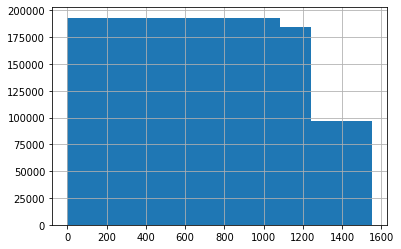

In [172]:
test['road_km'].hist()

<AxesSubplot:>

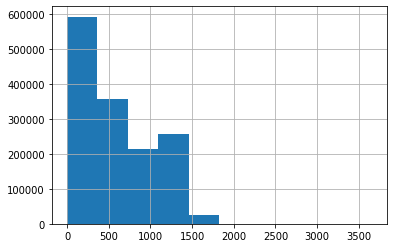

In [173]:
train['road_km'].hist()

In [55]:
del df

# Catboost

In [84]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(max_depth=5, iterations=30, loss_function='Logloss', custom_metric='F1', 
                       boosting_type='Plain', bootstrap_type='Bernoulli', subsample=0.2)# 'Plain')
clf.fit(tmp_train_x, tmp_train_y, eval_set = (tmp_test_x, tmp_test_y), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [85]:
clf.get_feature_importance(prettified=True)

Feature Id  Importances
0              road_km    28.533551
1   camera_amount_2_km    17.148095
2   camera_amount_1_km    14.271984
3              dt_year    11.178286
4            speed_min     7.464963
5              dt_hour     5.145151
6              road_id     4.385419
7   camera_amount_5_km     3.653910
8           volume_min     2.801968
9           volume_max     2.743416
10       occupancy_max     0.703302
11        dt_dayofyear     0.625008
12      occupancy_mean     0.501705
13          speed_mean     0.289216
14        dt_dayofweek     0.195602
15       occupancy_min     0.104790
16           speed_max     0.084264
17         volume_mean     0.079464
18    dt_monthProgress     0.048560
19              dt_day     0.041346

In [86]:
predicted_target = clf.predict(tmp_test_x)
# оценим модель на тестово сэмпле
f1_score(tmp_test_y, predicted_target, average='macro')

0.6860667268922628

### 3. Проверка на основной тестовой выборке (предсказание)

In [87]:
train_pred = clf.predict(train[clf.feature_names_])
pd.Series(train_pred).value_counts()

0    4118173
1       9015
dtype: int64

In [88]:
test_pred = clf.predict(test[clf.feature_names_])
# pd.Series(test_pred.T[0]).value_counts()
pd.Series(test_pred).value_counts()

1    1693987
0      35464
dtype: int64

In [89]:
test_proba = clf.predict_proba(test[clf.feature_names_])
test_proba

array([[6.20751695e-03, 9.93792483e-01],
       [3.46376561e-04, 9.99653623e-01],
       [2.36199550e-04, 9.99763800e-01],
       ...,
       [1.10090971e-03, 9.98899090e-01],
       [2.04152897e-03, 9.97958471e-01],
       [2.52674278e-01, 7.47325722e-01]])

In [81]:
test_pred = (test_proba[:,1] > 0.90).astype(int)
test_pred.mean()

0.0

In [90]:
test['target'] = test_pred
test

/home/nikolay/anaconda3/envs/hack/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Unnamed: 0             datetime  road_id  road_km  target  type  \
3427        1248993  2020-01-01 01:00:00        9        0       1  test   
3428        1248994  2020-01-01 01:00:00        9       19       1  test   
3429        1248995  2020-01-01 01:00:00        9       18       1  test   
3430        1248996  2020-01-01 01:00:00        9        1       1  test   
3431        1248997  2020-01-01 01:00:00        9        2       1  test   
...             ...                  ...      ...      ...     ...   ...   
2886833     2514618  2020-10-25 23:00:00       14       38       1  test   
2886834     2514619  2020-10-25 23:00:00       14       39       1  test   
2886835     2514620  2020-10-25 23:00:00       14       40       1  test   
2886836     2514621  2020-10-25 23:00:00       14       42       1  test   
2886837     2514622  2020-10-25 23:00:00       14       41       1  test   

         camera_closest_idx  camera_closest_idx_km  volume_mean  volume_max  \
3427                     25                     25          NaN         NaN   
3428                     25                     25          NaN         NaN   
3429                     25                     25          NaN         NaN   
3430                     25                     25          NaN         NaN   
3431                     25                     25          NaN         NaN   
...                     ...                    ...          ...         ...   
2886833                  31                     31          NaN         NaN   
2886834                  31                     31          NaN         NaN   
2886835                  31                     31          NaN         NaN   
2886836                  31                     31          NaN         NaN   
2886837                  31                     31          NaN         NaN   

         volume_min  occupancy_mean  occupancy_max  occupancy_min  speed_mean  \
3427            NaN             NaN            NaN            NaN         NaN   
3428            NaN             NaN            NaN            NaN         NaN   
3429            NaN             NaN            NaN            NaN         NaN   
3430            NaN             NaN            NaN            NaN         NaN   
3431            NaN             NaN            NaN            NaN         NaN   
...             ...             ...            ...            ...         ...   
2886833         NaN             NaN            NaN            NaN         NaN   
2886834         NaN             NaN            NaN            NaN         NaN   
2886835         NaN             NaN            NaN            NaN         NaN   
2886836         NaN             NaN            NaN            NaN         NaN   
2886837         NaN             NaN            NaN            NaN         NaN   

         speed_max  speed_min  camera_closest_dist  camera_amount_1_km  \
3427           NaN        NaN                 17.0                   0   
3428           NaN        NaN                  2.0                   0   
3429           NaN        NaN                  1.0                   0   
3430           NaN        NaN                 16.0                   0   
3431           NaN        NaN                 15.0                   0   
...            ...        ...                  ...                 ...   
2886833        NaN        NaN                  3.0                   0   
2886834        NaN        NaN                  2.0                   0   
2886835        NaN        NaN                  1.0                   0   
2886836        NaN        NaN                  1.0                   0   
2886837        NaN        NaN                  0.0                   1   

         camera_amount_2_km  camera_amount_5_km  dt_year  dt_hour  \
3427                      0                   0        1        1   
3428                      0                   3        1        1   
3429                      1                   2        1        1   
3430     

In [64]:
test[['datetime', 'road_id', 'road_km', 'target']]

datetime  road_id  road_km  target
3427     2020-01-01 01:00:00        9        0       0
3428     2020-01-01 01:00:00        9       19       0
3429     2020-01-01 01:00:00        9       18       0
3430     2020-01-01 01:00:00        9        1       0
3431     2020-01-01 01:00:00        9        2       0
...                      ...      ...      ...     ...
2886833  2020-10-25 23:00:00       14       38       1
2886834  2020-10-25 23:00:00       14       39       1
2886835  2020-10-25 23:00:00       14       40       1
2886836  2020-10-25 23:00:00       14       42       1
2886837  2020-10-25 23:00:00       14       41       1

[1729451 rows x 4 columns]

#### Предсказание и оценка модели

In [65]:
prediction = test[test['target'] != 0][['datetime','road_id','road_km','target']]
prediction.to_csv('submissions/sub3.csv', index=False)

In [82]:
test.isna().sum() / test.shape[0]

Unnamed: 0               0.000000
datetime                 0.000000
road_id                  0.000000
road_km                  0.000000
target                   0.000000
type                     0.000000
camera_closest_idx       0.000000
camera_closest_idx_km    0.000000
volume_mean              0.155186
volume_max               0.155186
volume_min               0.155186
occupancy_mean           0.155186
occupancy_max            0.155186
occupancy_min            0.155186
speed_mean               0.155186
speed_max                0.155186
speed_min                0.155186
camera_closest_dist      0.000000
camera_amount_1_km       0.000000
camera_amount_2_km       0.000000
camera_amount_5_km       0.000000
dt_year                  0.000000
dt_hour                  0.000000
dt_dayofweek             0.000000
dt_day                   0.000000
dt_dayofyear             0.000000
dt_monthProgress         0.000000
dtype: float64

#### Обагащение выборки переменными из датасетов `traffic.csv`, `repair.csv`

In [148]:
test.describe()

road_id       road_km        target  camera_closest_idx  \
count  1.729451e+06  1.729451e+06  1.729451e+06        1.729451e+06   
mean   1.179178e+01  7.029550e+02  1.559663e-01        1.511383e+01   
std    2.482915e+00  4.166274e+02  3.628235e-01        9.436997e+00   
min    9.000000e+00  0.000000e+00  0.000000e+00        0.000000e+00   
25%    9.000000e+00  3.470000e+02  0.000000e+00        7.000000e+00   
50%    1.400000e+01  6.940000e+02  0.000000e+00        1.500000e+01   
75%    1.400000e+01  1.041000e+03  0.000000e+00        2.200000e+01   
max    1.400000e+01  1.550000e+03  1.000000e+00        3.300000e+01   

       camera_closest_idx_km   volume_mean    volume_max    volume_min  \
count           1.729451e+06  1.461077e+06  1.461077e+06  1.461077e+06   
mean            1.449497e+01  1.247901e+02  1.655320e+02  8.709465e+01   
std             9.501416e+00  1.645474e+02  2.450440e+02  1.256267e+02   
min             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%             6.000000e+00  2.750000e+01  3.700000e+01  1.200000e+01   
50%             1.400000e+01  6.550000e+01  8.600000e+01  4.000000e+01   
75%             2.000000e+01  1.510000e+02  1.900000e+02  1.080000e+02   
max             3.300000e+01  2.833000e+03  5.308000e+03  2.833000e+03   

       occupancy_mean  occupancy_max  occupancy_min    speed_mean  \
count    1.461077e+06   1.461077e+06   1.461077e+06  1.461077e+06   
mean     5.105162e+00   7.056806e+00   3.433911e+00  6.858307e+01   
std      6.885926e+00   1.087743e+01   5.279505e+00  2.000331e+01   
min      0.000000e+00   0.000000e+00   0.000000e+00  0.000000e+00   
25%      1.097656e+00   1.490000e+00   6.718750e-01  5.852146e+01   
50%      2.511719e+00   3.378906e+00   1.488281e+00  7.145000e+01   
75%      6.305000e+00   8.011719e+00   4.019531e+00  8.239333e+01   
max      1.000000e+02   1.000000e+02   1.000000e+02  1.988769e+02   

          speed_max     speed_min  camera_closest_dist  camera_amount_1_km  \
count  1.461077e+06  1.461077e+06         1.729451e+06        1.729451e+06   
mean   7.685840e+01  5.906610e+01         1.882423e+01        2.413540e-02   
std    2.086840e+01  2.506187e+01         1.772387e+01        1.534695e-01   
min    0.000000e+00  0.000000e+00         0.000000e+00        0.000000e+00   
25%    6.783000e+01  4.478375e+01         6.000000e+00        0.000000e+00   
50%    7.866688e+01  6.610000e+01         1.400000e+01        0.000000e+00   
75%    8.870000e+01  7.740000e+01         2.600000e+01        0.000000e+00   
max    1.999500e+02  1.988769e+02         9.300000e+01        1.000000e+00   

       camera_amount_2_km  camera_amount_5_km    dt_year       dt_hour  \
count        1.729451e+06        1.729451e+06  1729451.0  1.729451e+06   
mean         7.240621e-02        2.172186e-01        1.0  1.151846e+01   
std          2.619246e-01        4.523460e-01        0.0  6.912376e+00   
min          0.000000e+00        0.000000e+00        1.0  0.000000e+00   
25%          0.000000e+00        0.000000e+00        1.0  6.000000e+00   
50%          0.000000e+00        0.000000e+00        1.0  1.200000e+01   
75%          0.000000e+00        0.000000e+00        1.0  1.800000e+01   
max          2.000000e+00        3.000000e+00        1.0  2.300000e+01   

       dt_dayofweek        dt_day  dt_dayofyear  dt_monthProgress  
count  1.729451e+06  1.729451e+06  1.729451e+06      1.729451e+06  
mean   4.194223e+00  1.325040e+01  1.607560e+02      5.699581e-01  
std    1.942801e+00  7.153546e+00  1.051576e+02      2.294098e-01  
min    1.000000e+00  1.000000e+00  1.000000e+00      1.935484e-01  
25%    3.000000e+00  7.000000e+00  9.800000e+01      3.870968e-01  
50%    4.000000e+00  1.400000e+01  1.960000e+02      5.483871e-01  
75%    6.000000e+00  1.900000e+01  2.930000e+02      7.666667e-01  
max    7.000000e+00  2.500000e+01  2.990000e+02      9.677419e-01

/home/nikolay/anaconda3/envs/hack/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
set(test_pred)

{0.0, 1.0, 2.0}

In [102]:
test['target'].value_counts()

0    1729451
Name: target, dtype: int64

In [122]:
test_proba[0]

array([1.44786735e-04, 6.63187876e-01, 3.36667337e-01])

# Code snippets

In [146]:
test['target'].value_counts()

0    1459715
1     269736
Name: target, dtype: int64

In [70]:
# # Perform interpolation. Works but too slow for this task
# pd.merge_asof(left=df, right=traffic_mean, by=['datetime', 'camera_closest_idx_km'],
#               on=['datetime', 'camera_closest_idx_km']
#               direction="nearest", left_index=True, right_index=True,
#              )

In [135]:
test[test['target'] != 0]

datetime  road_id  road_km data_source  target  type  \
12045  2020-01-01 01:00:00        9      1.0         NaN     2.0  test   
12051  2020-01-01 01:00:00        9      7.0         NaN     2.0  test   
12052  2020-01-01 01:00:00        9      8.0         NaN     2.0  test   
12053  2020-01-01 01:00:00        9     10.0         NaN     2.0  test   
12054  2020-01-01 01:00:00        9     11.0         NaN     2.0  test   
...                    ...      ...      ...         ...     ...   ...   
972306 2020-10-25 23:00:00       14      2.0         NaN     2.0  test   
972307 2020-10-25 23:00:00       14      3.0         NaN     2.0  test   
972308 2020-10-25 23:00:00       14      4.0         NaN     2.0  test   
972309 2020-10-25 23:00:00       14      5.0         NaN     2.0  test   
972310 2020-10-25 23:00:00       14      6.0         NaN     2.0  test   

        camera_closest_idx  camera_closest_idx_km  volume_mean  volume_max  \
12045                   25                     25          NaN         NaN   
12051                   25                     25          NaN         NaN   
12052                   25                     25          NaN         NaN   
12053                   25                     25          NaN         NaN   
12054                   25                     25          NaN         NaN   
...                    ...                    ...          ...         ...   
972306                   8                      8          NaN         NaN   
972307                   8                      8          NaN         NaN   
972308                   8                      8          NaN         NaN   
972309                   8                      8          NaN         NaN   
972310                   8                      8          NaN         NaN   

        volume_min  occupancy_mean  occupancy_max  occupancy_min  speed_mean  \
12045          NaN             NaN            NaN            NaN         NaN   
12051          NaN             NaN            NaN            NaN         NaN   
12052          NaN             NaN            NaN            NaN         NaN   
12053          NaN             NaN            NaN            NaN         NaN   
12054          NaN             NaN            NaN            NaN         NaN   
...            ...             ...            ...            ...         ...   
972306         NaN             NaN            NaN            NaN         NaN   
972307         NaN             NaN            NaN            NaN         NaN   
972308         NaN             NaN            NaN            NaN         NaN   
972309         NaN             NaN            NaN            NaN         NaN   
972310         NaN             NaN            NaN            NaN         NaN   

        speed_max  speed_min  camera_closest_dist  camera_amount_1_km  \
12045         NaN        NaN                 16.0                   0   
12051         NaN        NaN                 10.0                   0   
12052         NaN        NaN                  9.0                   0   
12053         NaN        NaN                  7.0                   0   
12054         NaN        NaN                  6.0                   0   
...           ...        ...                  ...                 ...   
972306        NaN        NaN                 14.0                   0   
972307        NaN        NaN                 13.0                   0   
972308        NaN        NaN                 12.0                   0   
972309        NaN        NaN                 11.0                   0   
972310        NaN        NaN                 10.0                   0   

        camera_amount_2_km  camera_amount_5_km  dt_year  dt_hour  \
12045                    0                   0        1        1   
12051                    0                   0        1        1   
12052                    0                   0        1        1   
12053                    0                   0        1        1   
12054         

In [ ]:
### Very slow implementation of statistics aggregation


# def map_traffic(x):
#     cond1 = traffic['datetime'] == x['datetime'] 
#     cond2 = traffic['road_km'] == x['camera_closest_idx_km'] 
#     res = traffic[cond1 & cond2]
        
#     res = res[['direction', 'volume', 'occupancy', 'speed']].describe()[['volume', 'occupancy', 'speed']].to_dict()
    
#     volume = res['volume']
#     volume['mean'], volume['min'], volume['max'], volume['std']
    
#     occupancy = res['occupancy']
#     occupancy['mean'], occupancy['min'], occupancy['max'], occupancy['std']

#     speed = res['speed']
#     speed['mean'], speed['min'], speed['max'], speed['std']

#     return [volume['mean'], volume['min'], volume['max'], volume['std'], \
#            occupancy['mean'], occupancy['min'], occupancy['max'], occupancy['std'], \
#            speed['mean'], speed['min'], speed['max'], speed['std']]

# def map_traffic2(x):
#     cond1 = traffic['datetime'] == x['datetime'] 
#     cond2 = traffic['road_km'] == x['camera_closest_idx_km'] 
#     res = traffic[cond1 & cond2]
        
#     return res[['volume', 'occupancy', 'speed']].mean()


# traffic_cols = ['volume_mean', 'volume_min', 'volume_max', 'volume_std', 
#                 'occupancy_mean', 'occupancy_min', 'occupancy_max', 'occupancy_std', 
#                 'speed_mean', 'speed_min', 'speed_max', 'speed_std']

# traffic_cols2 = ['volume', 'occupancy', 'speed']


# df[traffic_cols2] = df[['datetime', 'camera_closest_idx_km']].apply(map_traffic2, axis=1, result_type='expand')
# df
